In [1]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
with open("./data/en_US.blogs.txt", "r", encoding = "utf8") as f:
    data = f.read()

In [4]:
def tokenize(data):
    sentences = data.split("\n")
    joined_text = " ".join([sentence.strip() for sentence in sentences])
    partial_text = joined_text[:200000]
    tokenizer = RegexpTokenizer(r"\w+")
    tokens = tokenizer.tokenize(partial_text.lower())
    return tokens

In [5]:
tokens = tokenize(data)

In [6]:
unique_tokens = np.unique(tokens)
unique_token_index = {token: idx for idx, token in enumerate(unique_tokens)}

In [7]:
n_words = 8
input_words = []
next_words = []

In [8]:
for i in range(len(tokens) - n_words):
    input_words.append(tokens[i:i+n_words])
    next_words.append(tokens[i+n_words])

In [9]:
X = np.zeros((len(input_words), n_words, len(unique_tokens)), dtype=bool) # n_words bag of words with one position set to 1 (ten times of this)
y = np.zeros((len(next_words), len(unique_tokens))) # only one set to 1

In [10]:
for i, words in enumerate(input_words):
    for j,word in enumerate(words):
        X[i,j, unique_token_index[word]] = 1
    y[i, unique_token_index[next_words[i]]] = 1

In [11]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X,y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp,Y_temp, test_size=0.5, random_state=42)

In [12]:
model = Sequential()
model.add(LSTM(256, input_shape = (n_words, len(unique_tokens)), return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(LSTM(256, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(len(unique_tokens), activation = 'softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 256)            7577600   
                                                                 
 dropout (Dropout)           (None, 8, 256)            0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 7143)              1835751   
                                                                 
Total params: 9,938,663
Trainable params: 9,938,663
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(loss="categorical_crossentropy", optimizer=RMSprop(learning_rate=0.005), metrics=["accuracy"])
history = model.fit(X_train,Y_train, batch_size=128, epochs=50, shuffle=True, validation_data=(X_val, Y_val))

Epoch 1/50
233/233 [==============================] - 12s 22ms/step - loss: 7.2701 - accuracy: 0.0466 - val_loss: 7.1368 - val_accuracy: 0.0452
Epoch 2/50
233/233 [==============================] - 7s 28ms/step - loss: 7.0761 - accuracy: 0.0480 - val_loss: 7.1419 - val_accuracy: 0.0452
Epoch 3/50
233/233 [==============================] - 6s 28ms/step - loss: 7.0369 - accuracy: 0.0480 - val_loss: 7.1611 - val_accuracy: 0.0452
Epoch 4/50
233/233 [==============================] - 6s 28ms/step - loss: 7.6382 - accuracy: 0.0477 - val_loss: 7.1270 - val_accuracy: 0.0452
Epoch 5/50
233/233 [==============================] - 7s 28ms/step - loss: 7.3822 - accuracy: 0.0479 - val_loss: 7.1550 - val_accuracy: 0.0452
Epoch 6/50
233/233 [==============================] - 6s 28ms/step - loss: 6.9198 - accuracy: 0.0480 - val_loss: 7.2300 - val_accuracy: 0.0452
Epoch 7/50
233/233 [==============================] - 6s 27ms/step - loss: 7.1644 - accuracy: 0.0480 - val_loss: 7.2854 - val_accuracy: 0.045

In [15]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


117/117 [==============================] - 1s 11ms/step - loss: 9.3356 - accuracy: 0.0600
Test Loss: 9.335623741149902, Test Accuracy: 0.060043081641197205


In [16]:
#model.save("myModel.h5")

In [17]:
#model = load_model("mymodel.h5")

In [18]:
def predict_next_word(input_text, n_best):
    input_text = input_text.lower()
    X = np.zeros((1,n_words,len(unique_tokens)))
    num_of_words = 0
    input_words = input_text.split()
    for i in range(len(input_words)-1, -1, -1):
        if num_of_words >= n_words:
            break
        if input_words[i] in unique_tokens_index.keys():
            X[0,n_words - num_of_words - 1,unique_tokens_index[input_words[i]]] = 1
            print(f"{input_words[i]}:{n_words - num_of_words - 1}")
            num_of_words += 1
        
    predictions = model.predict(X)[0]
    top_n_idx = np.argsort(predictions)[-n_best:][::-1]
    predicted_words = [list(unique_tokens_index.keys())[idx] for idx in top_n_idx]
    return predicted_words

In [19]:
possible = predict_next_word("This ensures that the model works with the",5)

NameError: name 'unique_tokens_index' is not defined

In [ ]:
print(possible)

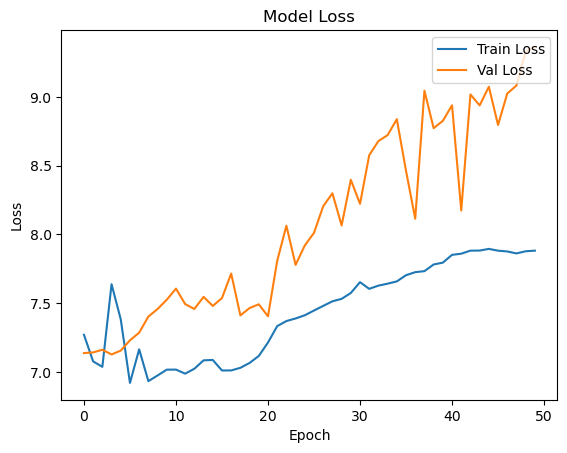

In [20]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


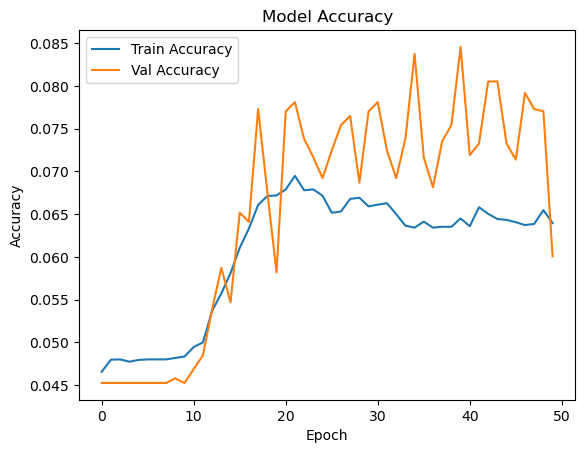

In [21]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()
